---
# Data Collection and Persistence
---

## Download GTZAN Dataset

### Install Dependencies

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


### Download the dataset and copy to the ./content/ directory.

In [2]:
import os
import site
from datasets import load_dataset
import shutil

dataset = load_dataset("marsyas/gtzan")

# Path to the dataset is in the /root/.cache/
# This path appears to just contain the audio files only. There may be another
# directory along this path that contains spectrograms, but if not, we can make
# them ourselves!
dataset_cache_dir = '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244'

# Destination directory in /content/
destination_dir = '/content/gtzan-dataset'

if os.path.exists(dataset_cache_dir):
    shutil.copytree(dataset_cache_dir, destination_dir)
    print("Dataset copied to:", destination_dir)
else:
    print("Dataset directory not found:", dataset_cache_dir)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for marsyas/gtzan contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/marsyas/gtzan
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.war

Generating train split: 0 examples [00:00, ? examples/s]

Dataset copied to: /content/gtzan-dataset


### Read in Audio Files:

In [4]:
from glob import glob

# Pattern to match .wav files in all genre directories
pattern = '/content/gtzan-dataset/genres/*/*.wav'

# Find all files matching the pattern
audio_files = glob(pattern)

# Print the number of audio files found
length = len(audio_files)
print("Number of .wav files in gtzan dataset: ", length)

Number of .wav files in gtzan dataset:  1000


### Play an audio file for testing purposes:

In [ ]:
import IPython.display as ipd

ipd.Audio(audio_files[0])

### Data Creator Function - Michael

This function will be used to organize and persist data after the feature files have been created.

In [ ]:
import librosa
import os


def create_spectrogram_dataset(dataset):
    """
    Load audio files given in the provided dataset.

    Usage:
        python3 dataset_creator.py

    Args:
        dataset (list): list of strings which are the file paths to the .wav audio files in the dataset

    Returns:
        dictionary of dictionaries which contains spectrogram data including: stft, mel, mfcc, harmonic, percussive, chroma, zero_crossing, tonnetz and a marking for genre.
    """
    # Dictionary to return
    spectrogram_dataset = {}
    for file_path in dataset:
        # Split the file into its genre and file number.
        split_file_name = os.path.basename(file_path).split('.')
        genre, file_number = split_file_name[0], split_file_name[1]
        try:
            # Attempt to catch corrupted files, load y for data and sr for sample rate.
            y, sr = librosa.load(file_path)

            stft = librosa.stft(y)                                      # Short-time fourier transform
            mel = librosa.feature.melspectrogram(y)                     # Mel Spectrogram
            mfcc = librosa.feature.mfcc(y)                              # Mel Frequency Cepstral Coefficients
            harmonic, percussive = librosa.feature.hpss(stft)           # Harmonic, Percussive Source Separation
            chroma = librosa.feature.chroma_stft(y, sr)                 # Chroma STFT
            zero_crossing = librosa.feature.zero_crossing_rate(y)[0]    # Zero Crossing Rate
            tonnetz = librosa.feature.tonnetz(y, sr)                    # Tonnetz

        except:
            continue
        spectrogram_dataset[file_number] = {                            # Form the dataset as a dict of dicts.
            'genre': genre,
            'stft': stft,
            'mel': mel,
            'mfcc': mfcc,
            'harmonic': harmonic,
            'percussive': percussive,
            'chroma': chroma,
            'zero_crossing': zero_crossing,
            'tonnetz': tonnetz
            }
    return spectrogram_dataset

---

# Feature Engineering

---



# Spectrogram (STFT), Mel Spectrogram, and MFCC - Elvin

In [5]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os


# def save_mfcc_and_mel_spect(audio_files = audio_files):

# dictinary to save data to return
data_dict = {'Genre': [],
             'STFT': [], # Short-time Fourier transform (STFT)
             'MFCC' : [],
             'Mel-Spect': []
            }

for i in range(0, len(audio_files)):
    try:
        y, sr = librosa.load(audio_files[i])
        # norm_y = librosa.util.normalize(y, norm=1)


        # y = numpy array of audio data
        # sr = sample rate

        # pulls out label from audio files
        data_dict['Genre'].append(os.path.basename(audio_files[i]).split('.')[0])

        # STFT
        data_dict['STFT'].append(np.abs(librosa.stft(y)))

        # Mel Spectograms
        data_dict['Mel-Spect'].append(librosa.feature.melspectrogram(y=y, sr=sr))

        # MFCC
        data_dict['MFCC'].append(librosa.feature.mfcc(y=y, sr=sr))

    except:  # try and catch to skip corrupted files!
      continue



<ipython-input-5-0cb062aaec22>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_files[i])
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


# Spectrograms (STFT), Mel Spectrograms, and MFCC Visualization - Elvin

disco


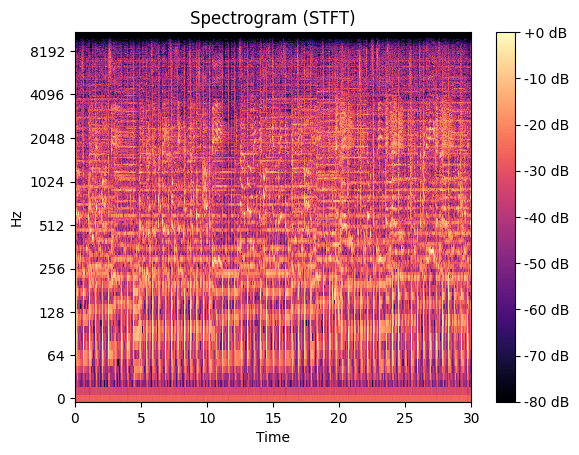

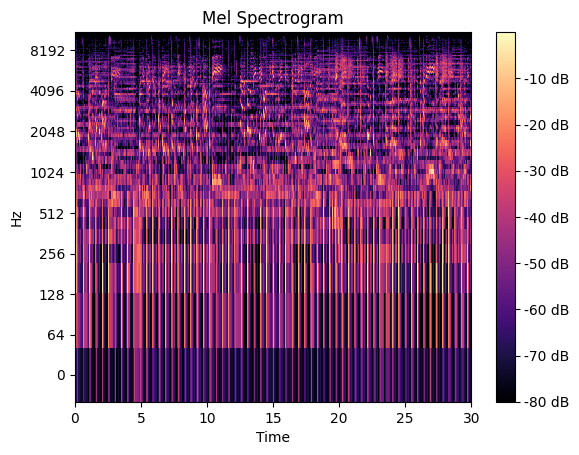

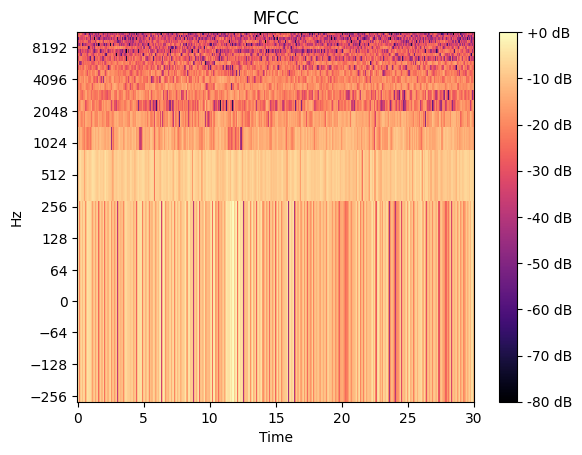

In [6]:
import matplotlib.pyplot as plt

print(data_dict['Genre'][0])

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(data_dict['STFT'][0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Spectrogram (STFT)')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(data_dict['Mel-Spect'][0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Mel Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")



fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(data_dict['MFCC'][0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('MFCC')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

# HPSS (Harmonic and Percussive Source Separation) - Michael



The code below decomposes a spectrogram into two separate spectrograms representing harmonic and percussive components.

audio_files: /content/gtzan-dataset/genres/jazz/jazz.00073.wav, datatype: <class 'str'>
y: -0.0758056640625, datatype: <class 'numpy.float32'>
shape y: (661794,)
sr: 22050


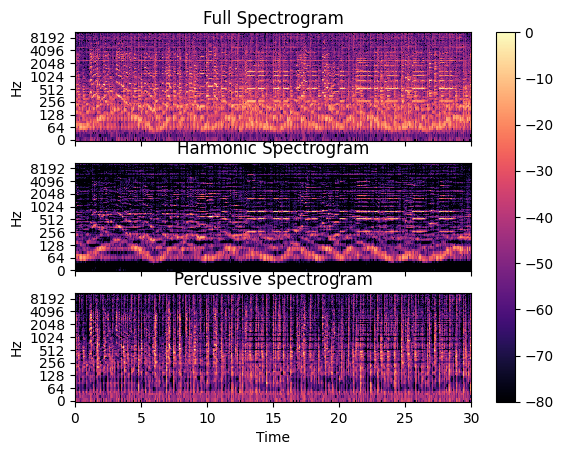

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

# audio_files = glob('/Users/vfbmediaml/Downloads/Data/genres_original/classical/*.wav')

y, sr = librosa.load(audio_files[0])
print(f'audio_files: {audio_files[0]}, datatype: {type(audio_files[0])}')
print(f'y: {y[0]}, datatype: {type(y[0])}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

D = librosa.stft(y)
D_harmonic, D_percussive = librosa.decompose.hpss(D, margin=4)        # Decompose harmonic and percussive components

rp = np.max(np.abs(D))    # Create Waveform Power reference point for plotting

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)

img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Full Spectrogram')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Harmonic Spectrogram')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[2])
ax[2].set(title='Percussive spectrogram')
fig.colorbar(img, ax=ax)

plt.show()

# Chromagrams, Chroma Features, Zero-Crossing Rate, and Tonnetz - Mark

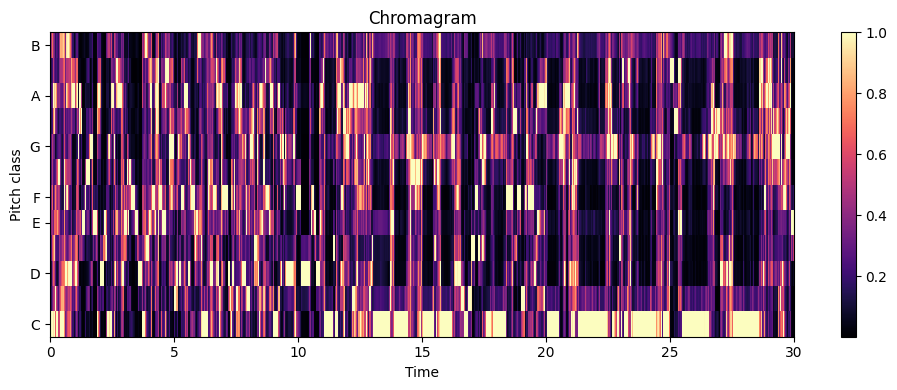

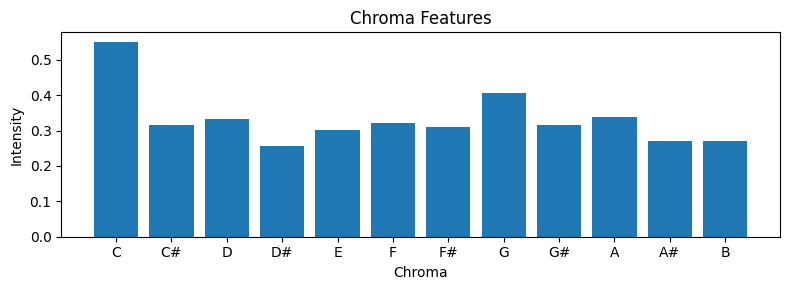

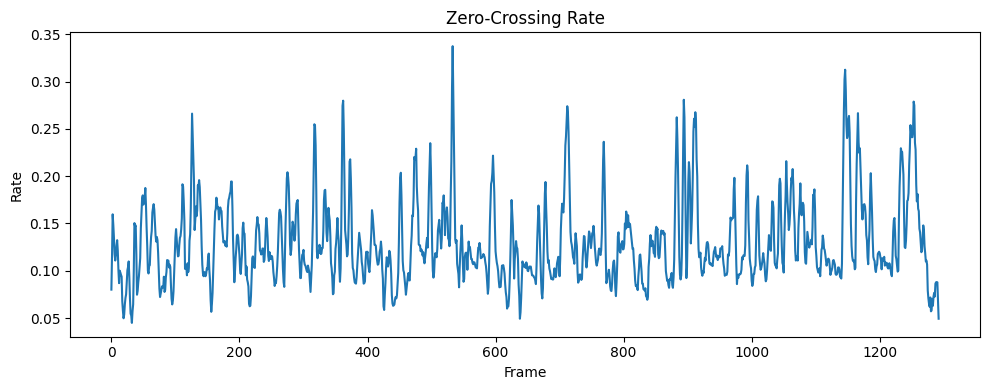

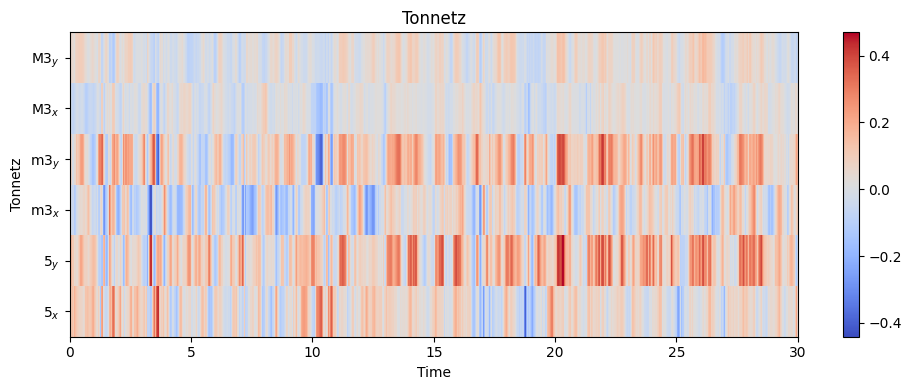

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
audio_path = audio_files[0]
y, sr = librosa.load(audio_path)

# Compute the Chromagram
chromagram = librosa.feature.chroma_stft(y=y, sr=sr)

# Display the Chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time', sr=sr)
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()

# Compute the Chroma Features (mean of the Chromagram)
chroma_features = chromagram.mean(axis=1)

# Display the Chroma Features
plt.figure(figsize=(8, 3))
plt.bar(range(12), chroma_features)
plt.title('Chroma Features')
plt.ylabel('Intensity')
plt.xlabel('Chroma')
plt.xticks(range(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.tight_layout()
plt.show()

# Compute Zero-Crossing Rate
zero_crossings = librosa.feature.zero_crossing_rate(y)[0]

# Display Zero-Crossing Rate
plt.figure(figsize=(10, 4))
plt.plot(zero_crossings)
plt.title('Zero-Crossing Rate')
plt.ylabel('Rate')
plt.xlabel('Frame')
plt.tight_layout()
plt.show()

# Compute Tonnetz
tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

# Display Tonnetz
plt.figure(figsize=(10, 4))
librosa.display.specshow(tonnetz, y_axis='tonnetz', x_axis='time')
plt.colorbar()
plt.title('Tonnetz')
plt.tight_layout()
plt.show()
